# Problem Statement

This project aims to predict the price for a list individual residential properties sold in Ames provided by [Kaggle](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge). Data set leveraged contains information from the Ames Assessor’s Office used in computing assessed values for individual residential properties sold in Ames, Iowa from 2006 to 2010. 

# Executive Summary

There's a ton of data to work with here, with 2930 total observations and 82 features. The approach of this project is to leverage linear regression along with regularization techniques (Ridge and Lasso) to predict the sales price on the test set provided by Kaggle. 

The overall approach is to first explore the data set, clean it and then model out a prediction. On the modelling approach, I first run a linear regression on all numeric features, reduce and eliminate features based on results, and select a couple of categorical features based on the exploratory data analysis to introduce into the model.

**Contents:**
- [Import Datasets and Libraries](#Import-Datasets-and-Libraries)
- [Exploratory Data Analysis](#EDA)
- [Feature Engineering](#Feature-Engineering)
- [Modelling](#Modelling)
- [Conclusion](#Conclusion)


# Data Cleaning and EDA

## Import Datasets and Libraries

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 80)

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    KFold,
)
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV

sns.set(style='white', context='talk')

Import dataset

In [2]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

for col in train.columns:
    train.rename(columns={col: col.replace(' ','')}, inplace=True)
for col in test.columns:
    test.rename(columns={col: col.replace(' ','')}, inplace=True)

## EDA

### Exploring features of interest

Sale Price vs. Houses Sold

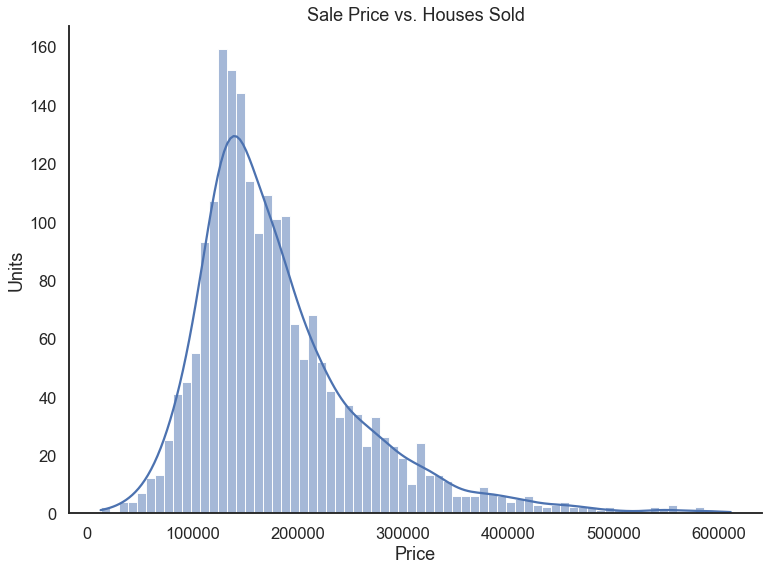

In [3]:
sns.displot(data=train['SalePrice'], bins=70, kde=True, height=8.27, aspect=4/3)
plt.title('Sale Price vs. Houses Sold')
plt.xlabel('Price')
plt.ylabel('Units')
plt.tight_layout()
plt.savefig('../images/eda1.png', transparent=True)

In [4]:
saleprice_mean = int(train['SalePrice'].mean())
saleprice_max = int(train['SalePrice'].max())
saleprice_min = int(train['SalePrice'].min())

In [5]:
print(f'The mean sale price is ${saleprice_mean}, where the most expensive house sold for ${saleprice_max} \
and the cheapest sold for ${saleprice_min}.')

The mean sale price is $181469, where the most expensive house sold for $611657 and the cheapest sold for $12789.


Housing Sales by Month

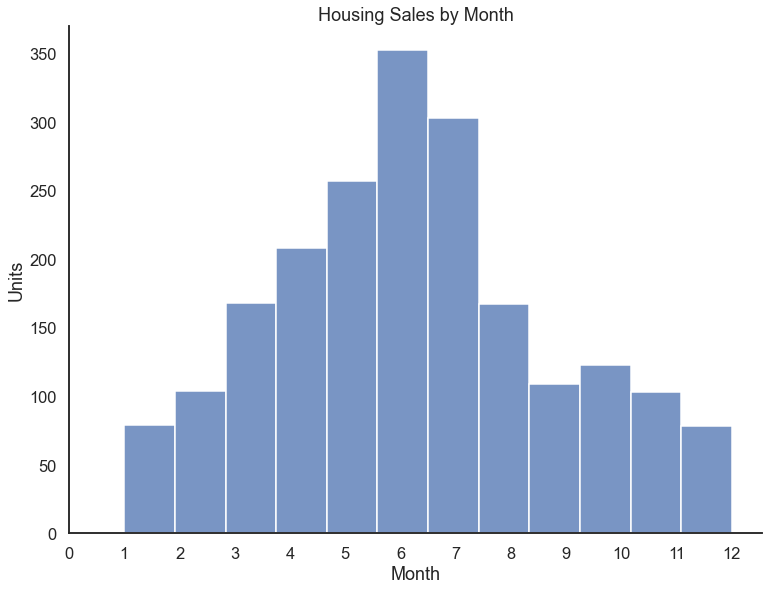

In [6]:
sns.displot(x=train['MoSold'], bins=12, height=8.27, aspect=4/3, kde=False)
plt.xticks(ticks=range(13))
plt.title('Housing Sales by Month')
plt.xlabel('Month')
plt.ylabel('Units')
plt.savefig('../images/eda2.png', transparent=True);

Interestingly, middle of the year looks to be the time where most houses are sold. However, this isin't very useful for this project.

Neighborhood data

<AxesSubplot:ylabel='Neighborhood'>

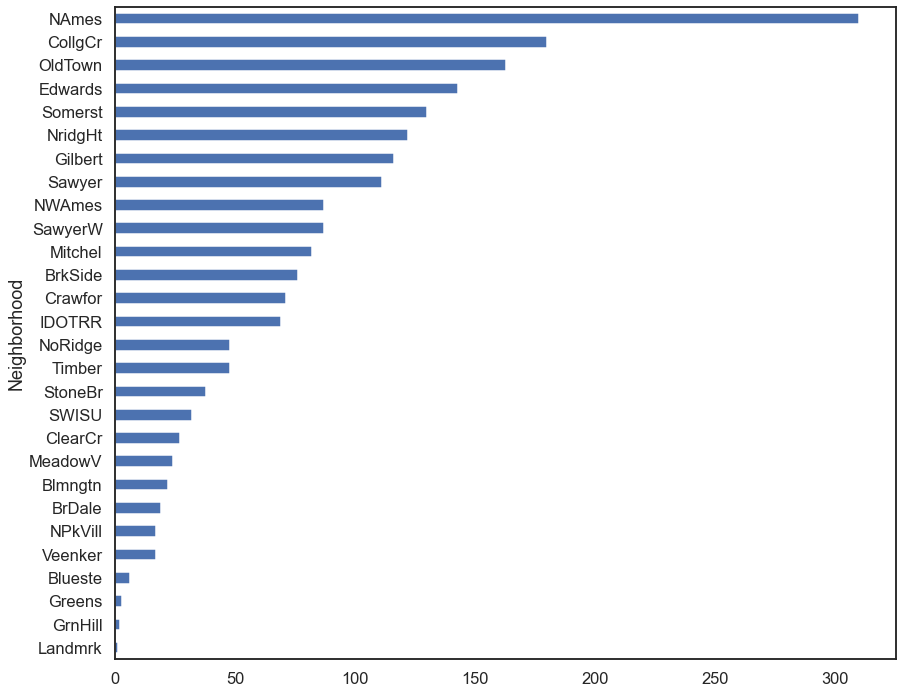

In [7]:
plt.figure(figsize=(14,12))
train.groupby('Neighborhood').Id.count().sort_values(ascending=True).plot(kind='barh')

It's observed that North Ames has the most housing sales.

In [8]:
boxplot = train.groupby('Neighborhood')[['SalePrice']].mean().sort_values(by='SalePrice', ascending=False)

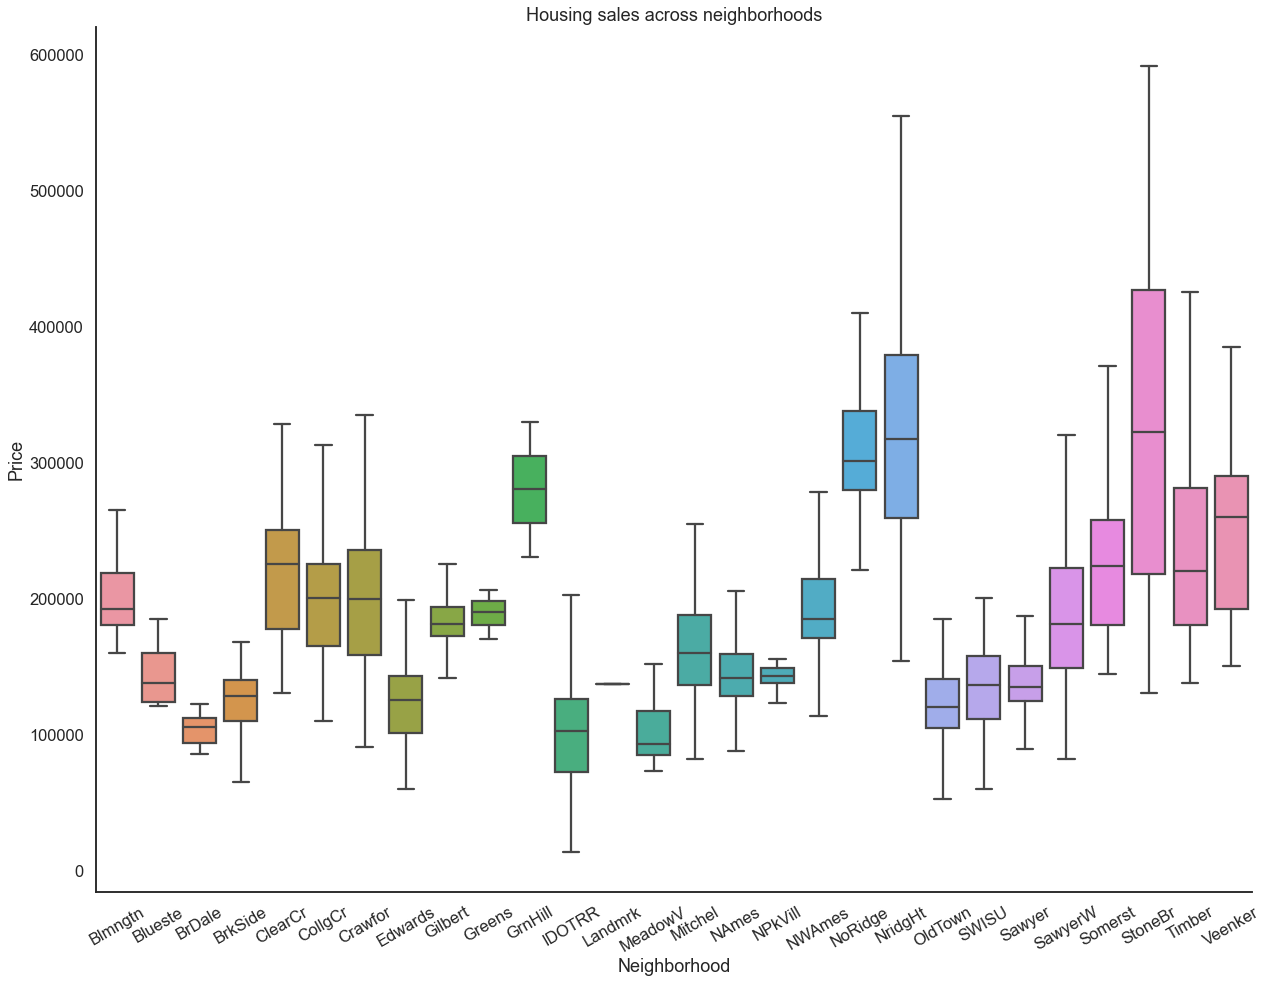

In [9]:
plt.figure(figsize=(18,14))
sns.boxplot(x=train['Neighborhood'].sort_values(ascending=True), y=train['SalePrice'], showfliers=False)
sns.despine()
plt.xticks(rotation=30)
plt.title('Housing sales across neighborhoods')
plt.tight_layout()
plt.ylabel('Price')
plt.savefig('../images/neigh.png', transparent=True);

We can see that neighborhood data provides fairly good indicator of house prices since the spread from a particular neighborhood is seemingly narrow enough. However, considering the number of features I may need to add to the model from this, I decided to omit this out from my model. 

### Deeper dive into numerical features

In [10]:
num_cols = train.select_dtypes(exclude=['object']).columns

In [11]:
def subplot_scatter(dataframe, list_of_columns, y):
    nrows = int(np.ceil(len(list_of_columns)/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(14,50))
    ax = ax.ravel()
    for i, col in enumerate(list_of_columns):
        sns.regplot(data=dataframe, x=dataframe[col], y=y, ax=ax[i])
    plt.xticks(rotation=30)
    plt.tight_layout()

In [12]:
#for ease of readability, have chosen to drop out features without significant patterns
num_cols = num_cols.drop([
    'Id', 
    'PID', 
    'MSSubClass', 
    'BsmtFinSF2', 
    '2ndFlrSF', 
    'LowQualFinSF',
    'BsmtUnfSF',
    'BsmtFullBath', 
    'BsmtHalfBath',
    'HalfBath',
    'BedroomAbvGr',
    'SalePrice',
    'KitchenAbvGr',
    'EnclosedPorch',
    'ScreenPorch',
    'PoolArea',
    '3SsnPorch',
    'YrSold',
    'MiscVal',
    'MoSold',
    'OpenPorchSF'
])

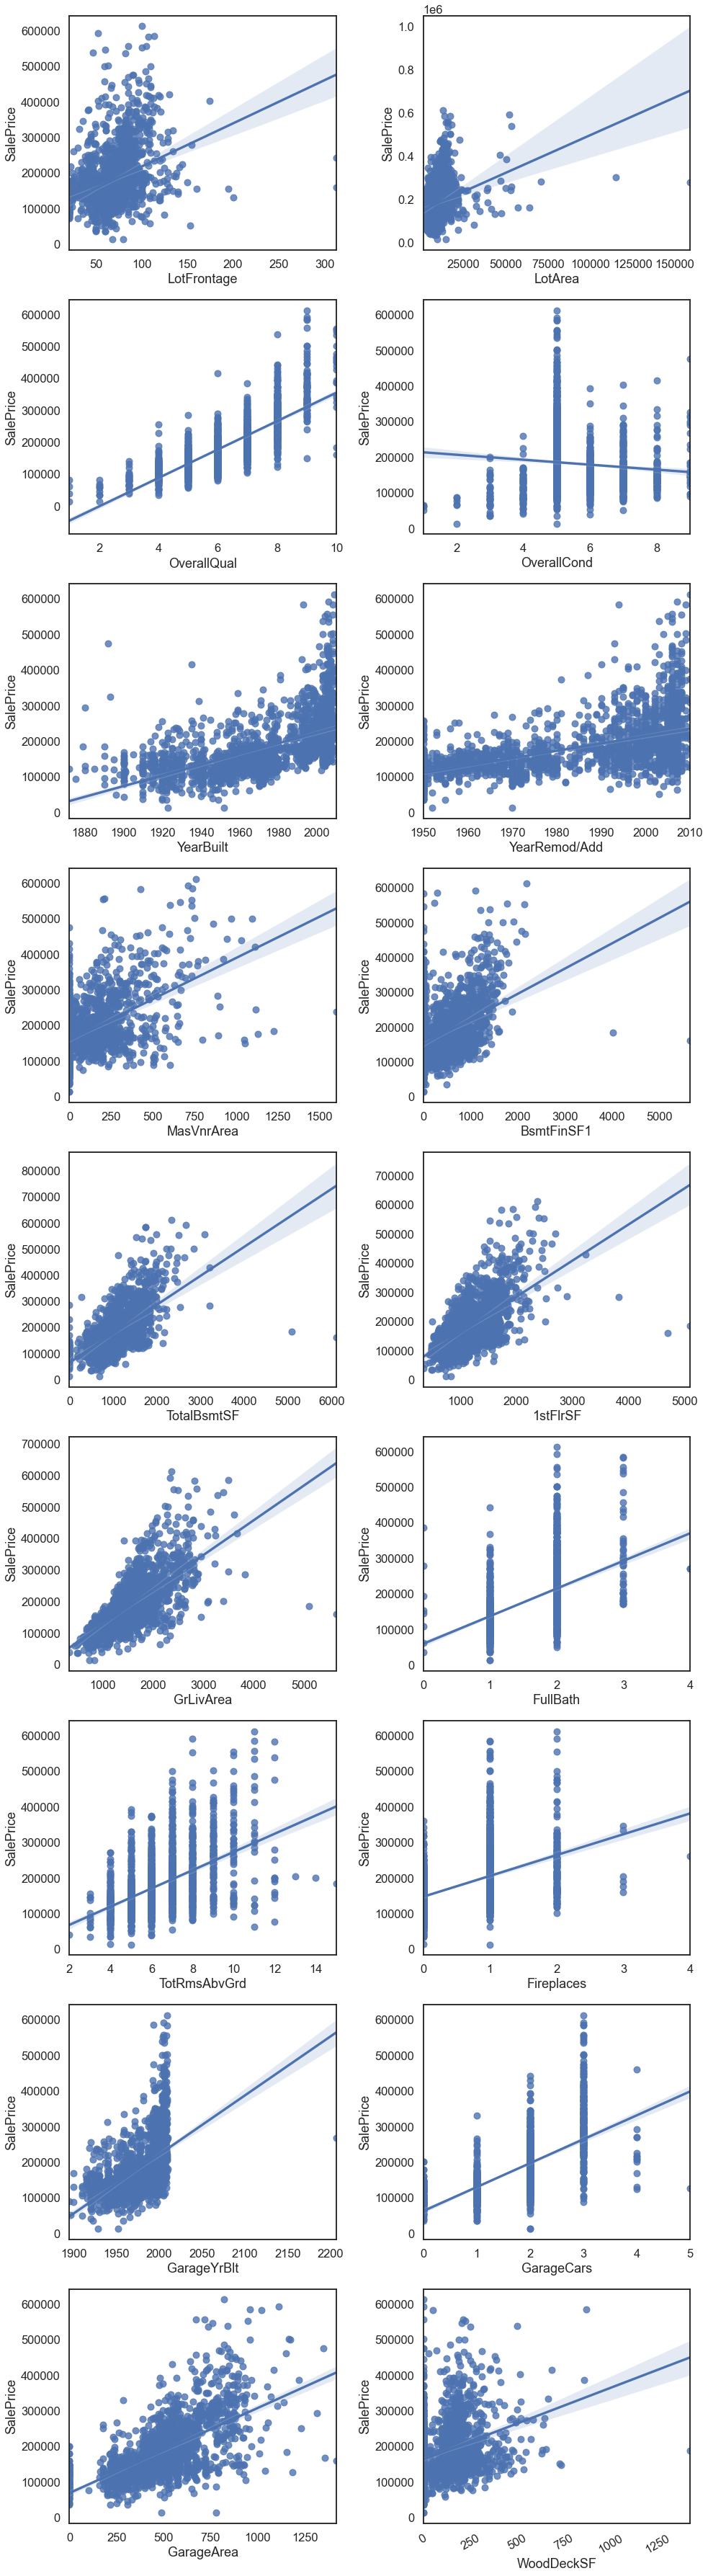

In [13]:
subplot_scatter(train, num_cols, train['SalePrice'])

Above we can see some rather strong relationships with sale price including total number of rooms, age, year of remodel, as well as size of house across various categories. 

### Deeper dive into categorical variables

In [14]:
cat_cols = [
    'MSZoning',
    'Street',
    'Alley',
    'LotShape',
    'LandContour',
    'LotConfig',
    'Neighborhood',
    'Condition1',
    'Condition2',
    'BldgType',
    'HouseStyle',
    'RoofStyle',
    'RoofMatl',
    'Exterior1st',
    'Exterior2nd',
    'MasVnrType',
    'Foundation',
    'BsmtFinType1',
    'BsmtFinType2',
    'CentralAir',
    'Heating',
    'Electrical',
    'GarageType',
    'MiscFeature',
    'SaleType'
]

In [15]:
def subplot_boxplot(dataframe, list_of_columns, y):
    nrows = int(np.ceil(len(list_of_columns)/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(14,50))
    ax = ax.ravel()
    for i, col in enumerate(list_of_columns):
        sns.boxplot(x=dataframe[col], y=y, ax=ax[i])
    plt.xticks(rotation=30)    
    plt.tight_layout()

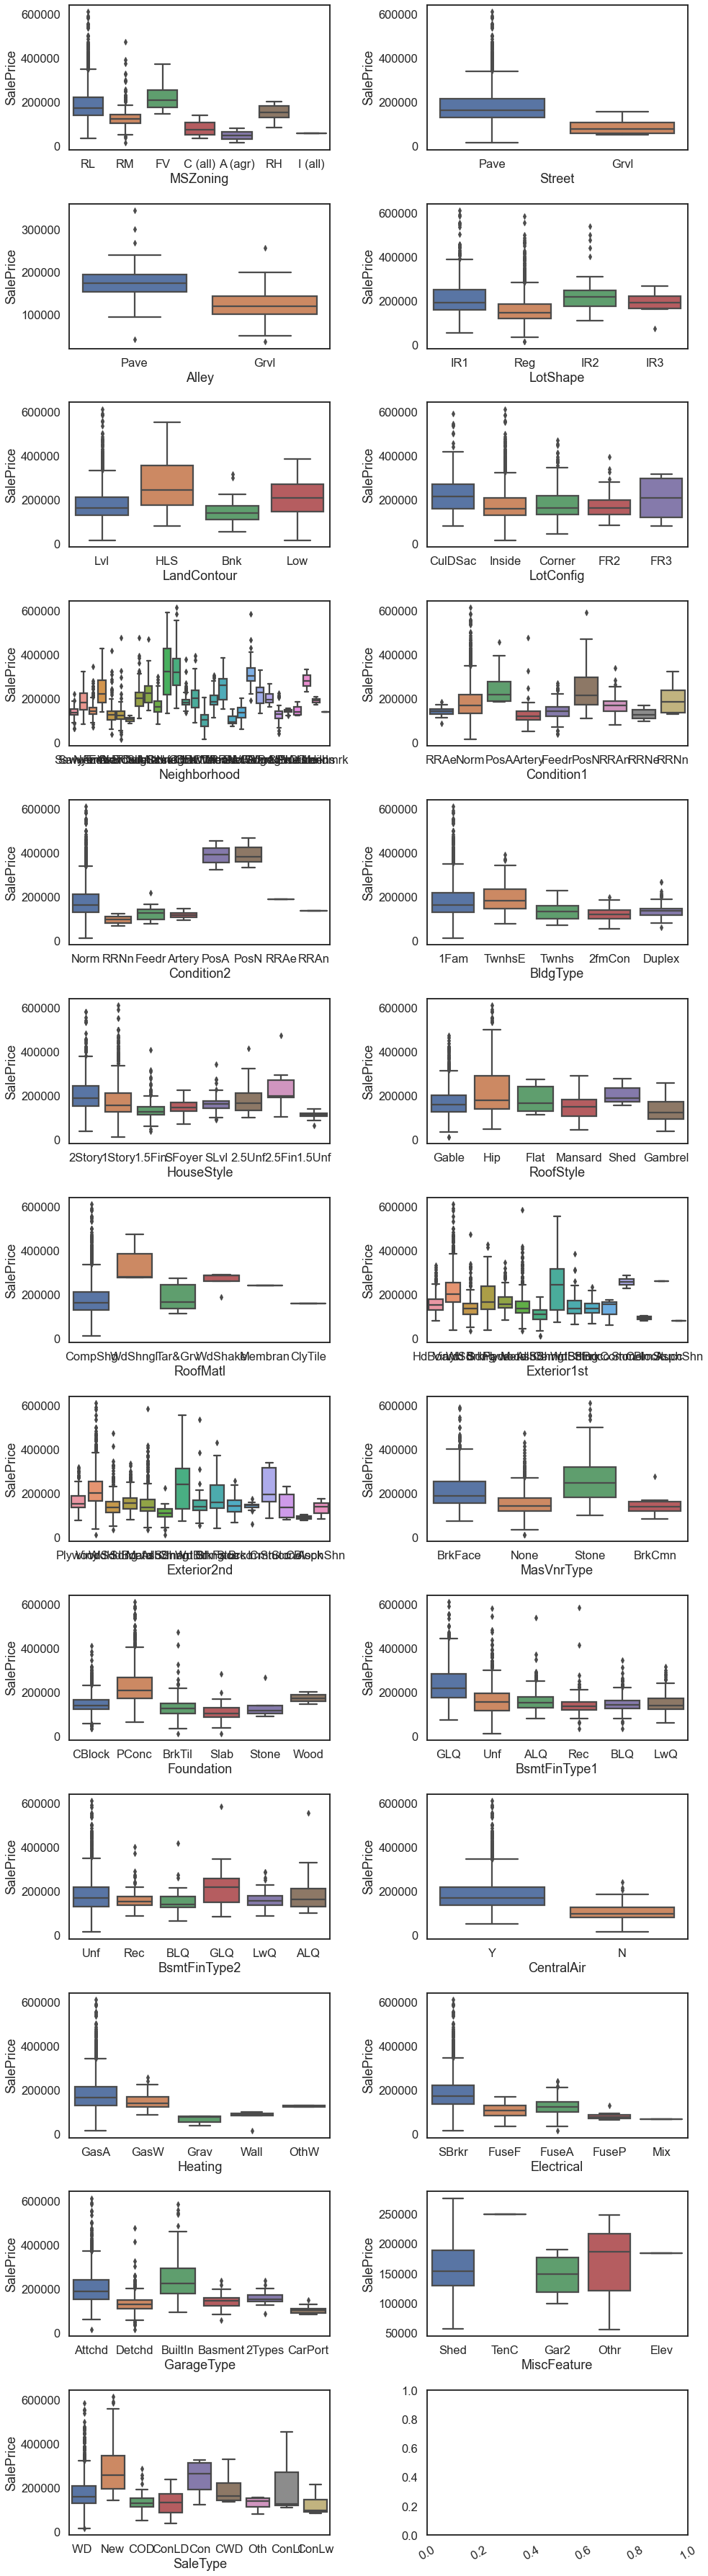

In [16]:
subplot_boxplot(train, cat_cols, train['SalePrice'])

Taking a look at the categorical plots, we probably want to pick on features where it gives a fairly good spread across its scores, and has a good distribution of values across the scores as well. I've selected Foundation and MSZoning to play around with my model in subsequent sections.

### Deeper dive into area related features

In [17]:
area_cols = [
    'MasVnrArea',
    'BsmtFinSF1',
    'TotalBsmtSF',
    '1stFlrSF',
    'GrLivArea',
    'GarageArea',
    'WoodDeckSF',
    'OpenPorchSF',
]

In [18]:
def subplot_scatter2(dataframe, list_of_columns, y):
    nrows = int(np.ceil(len(list_of_columns)/2))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(14,25))
    ax = ax.ravel()
    for i, col in enumerate(list_of_columns):
        sns.regplot(data=dataframe, x=dataframe[col], y=y, ax=ax[i])
    plt.xticks(rotation=30)
    plt.tight_layout()

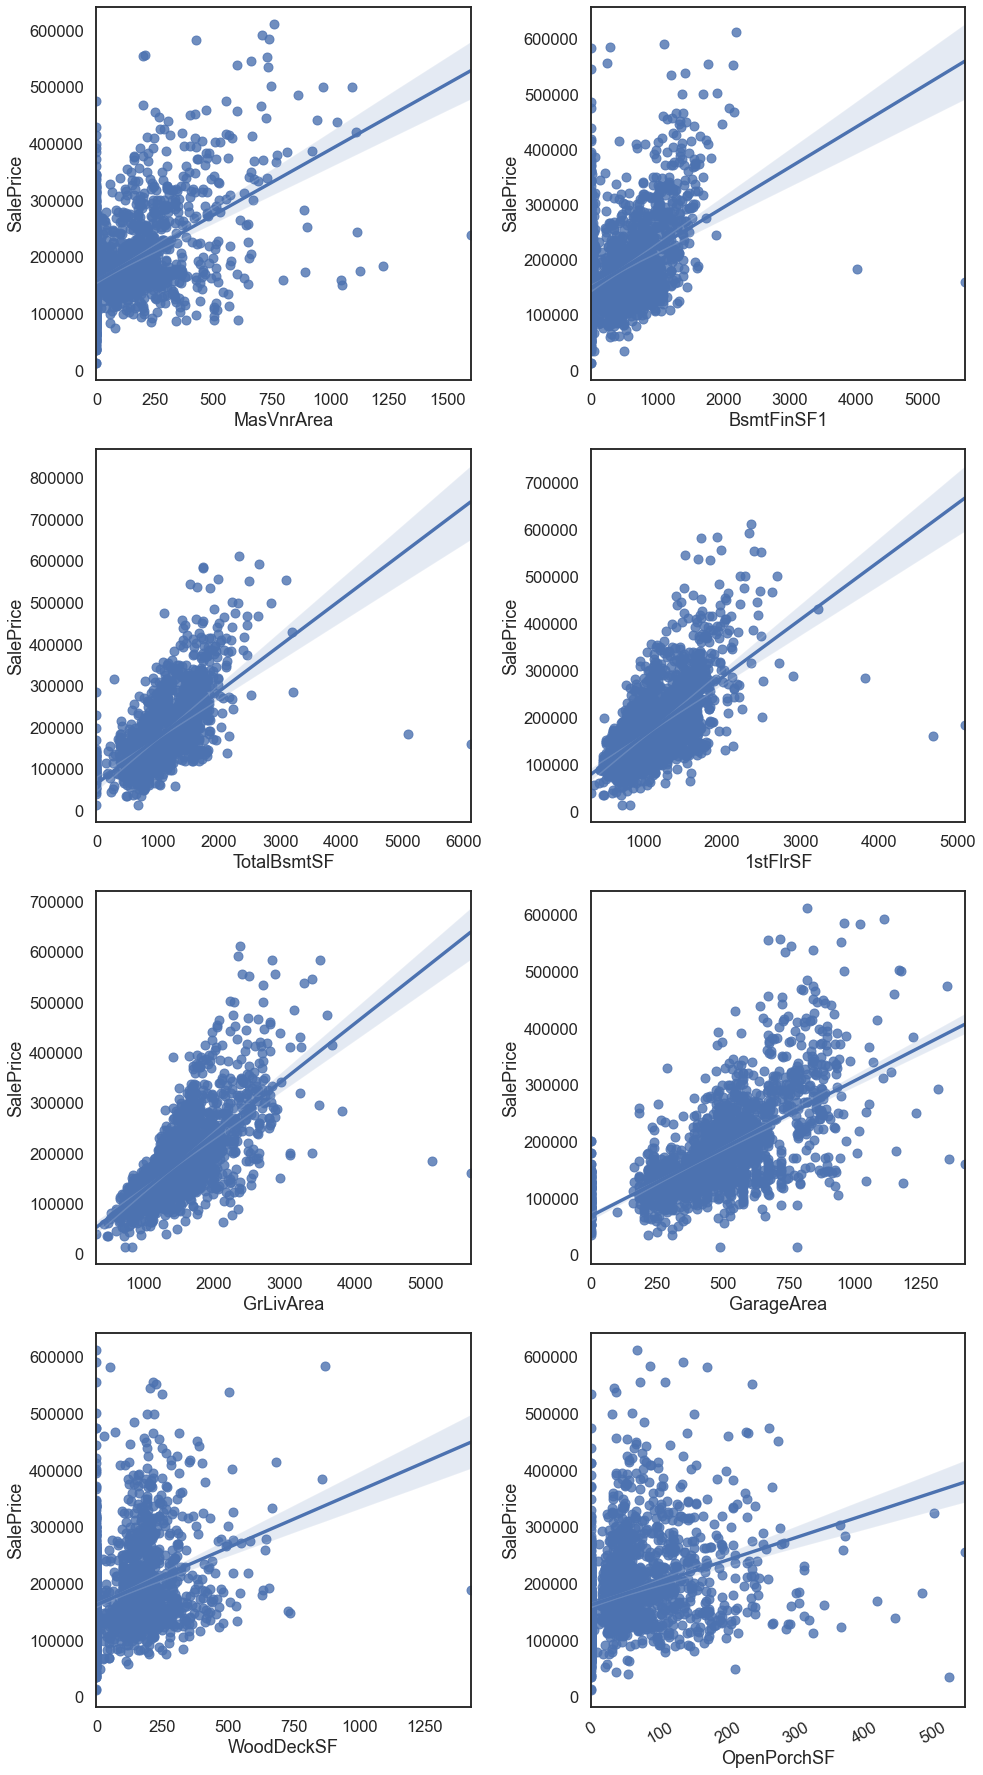

In [19]:
subplot_scatter2(train, area_cols, train['SalePrice'])
plt.savefig('../images/eda3.png', transparent=True)

We can intuitively infer multicollinearity from above findings. We'll attempt to solve this problem in feature engineering section.

### Correlations

Variables with significant correlation with `SalePrice`

<AxesSubplot:>

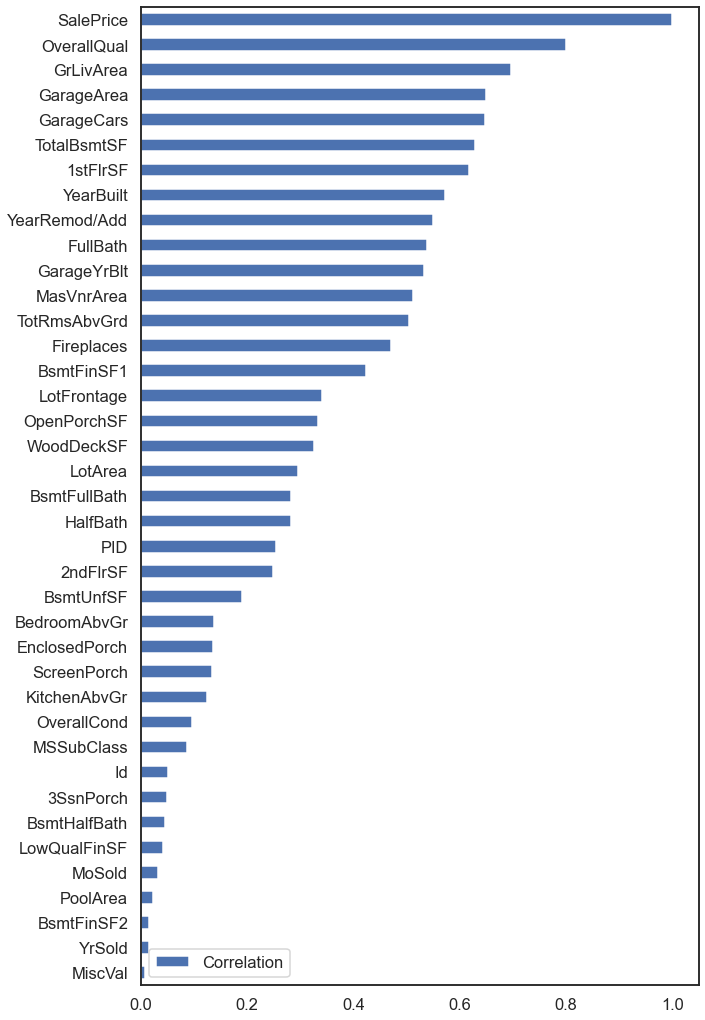

In [20]:
corrs = pd.DataFrame(abs(train.corr()['SalePrice']))
corrs.columns = ['Correlation']
corrs.sort_values(by='Correlation', ascending=True).plot(kind='barh', figsize=(10,18))

<AxesSubplot:>

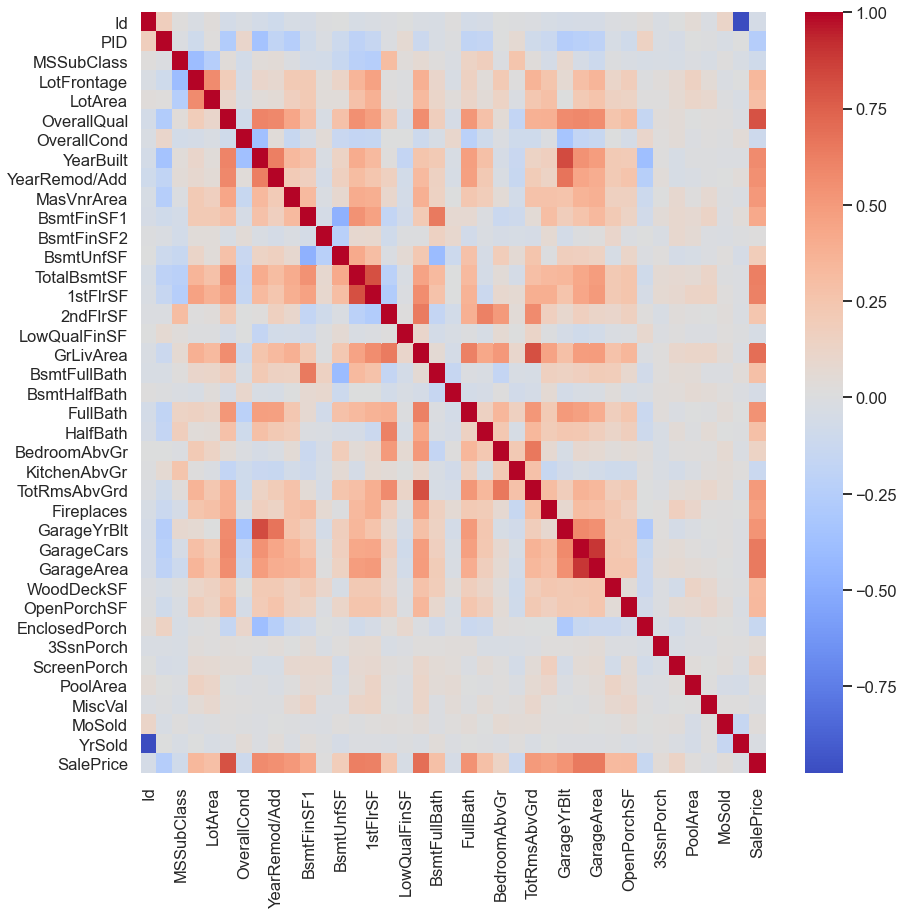

In [21]:
plt.figure(figsize=(14,14))
sns.heatmap(train.corr(), cmap='coolwarm')
#omit annotation due to clutter

In [22]:
df_corr = corrs.sort_values(by='Correlation', ascending=False)[1::]
df_corr = df_corr.drop(['Id', 'PID'])
df_corr

,Correlation
OverallQual,0.800207
GrLivArea,0.697038
GarageArea,0.650270
GarageCars,0.648220
TotalBsmtSF,0.628925
1stFlrSF,0.618486
YearBuilt,0.571849
YearRemod/Add,0.550370
FullBath,0.537969
GarageYrBlt,0.533922


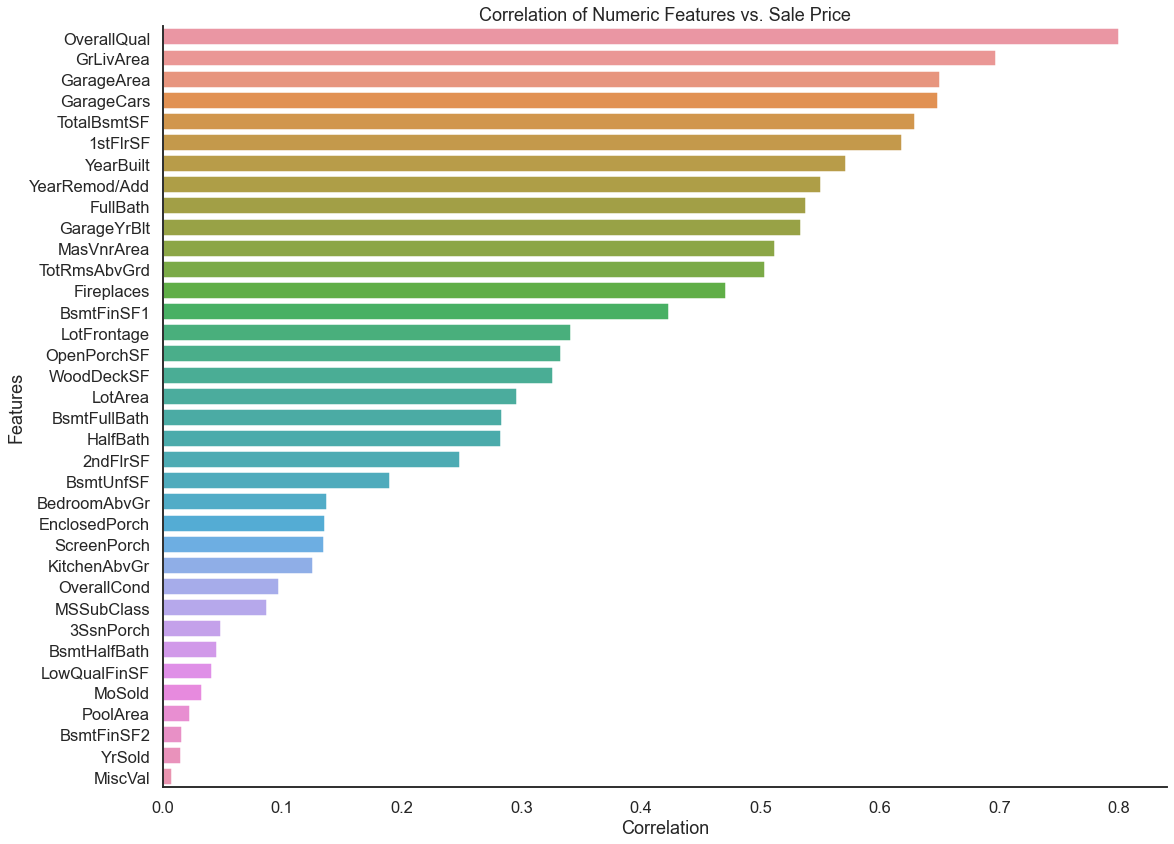

In [23]:
plt.figure(figsize=(18,14))
sns.barplot(y=df_corr.index, x=df_corr['Correlation'])
plt.title('Correlation of Numeric Features vs. Sale Price')
plt.ylabel('Features')
sns.despine()
plt.savefig('../images/eda4.png', transparent=True);

### Others

`MSZoning`

Remove `A (agr)` and `I (all)` rows

In [24]:
train['MSZoning'].value_counts()

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: MSZoning, dtype: int64

In [25]:
test['MSZoning'].value_counts()

RL         675
RM         146
FV          38
RH          13
C (all)      6
I (all)      1
Name: MSZoning, dtype: int64

## Data cleaning before train-test-split

### Converting ordinal feature values

In [26]:
train.Alley.replace({'Grvl':1, 'Pave':2}, inplace=True)
train.LotShape.replace({'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}, inplace=True)
train.LandContour.replace({'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4}, inplace=True)
train.Utilities.replace({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}, inplace=True)
train.LandSlope.replace({'Sev':1, 'Mod':2, 'Gtl':3}, inplace=True)
train.ExterQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train.ExterCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train.BsmtQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train.BsmtCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train.BsmtExposure.replace({'No':1, 'Mn':2, 'Av':3, 'Gd':4}, inplace=True)
train.BsmtFinType1.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
train.BsmtFinType2.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
train.HeatingQC.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train.KitchenQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train.Functional.replace({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}, inplace=True)
train.FireplaceQu.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train.GarageFinish.replace({'Unf':1, 'RFn':2, 'Fin':3}, inplace=True)
train.GarageQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train.GarageCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
train.PavedDrive.replace({'N':1, 'P':2, 'Y':3}, inplace=True)
train.CentralAir.replace({'Y':1, 'N':0}, inplace=True)

test.Alley.replace({'Grvl':1, 'Pave':2}, inplace=True)
test.LotShape.replace({'Reg':1, 'IR1':2, 'IR2':3, 'IR3':4}, inplace=True)
test.LandContour.replace({'Low':1, 'HLS':2, 'Bnk':3, 'Lvl':4}, inplace=True)
test.Utilities.replace({'ELO':1, 'NoSeWa':2, 'NoSewr':3, 'AllPub':4}, inplace=True)
test.LandSlope.replace({'Sev':1, 'Mod':2, 'Gtl':3}, inplace=True)
test.ExterQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
test.ExterCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
test.BsmtQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
test.BsmtCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
test.BsmtExposure.replace({'No':1, 'Mn':2, 'Av':3, 'Gd':4}, inplace=True)
test.BsmtFinType1.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
test.BsmtFinType2.replace({'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6}, inplace=True)
test.HeatingQC.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
test.KitchenQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
test.Functional.replace({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8}, inplace=True)
test.FireplaceQu.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
test.GarageFinish.replace({'Unf':1, 'RFn':2, 'Fin':3}, inplace=True)
test.GarageQual.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
test.GarageCond.replace({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}, inplace=True)
test.PavedDrive.replace({'N':1, 'P':2, 'Y':3}, inplace=True)
test.CentralAir.replace({'Y':1, 'N':0}, inplace=True)

### Cleaning null values (fill NAs only)

Check for count of nulls

In [27]:
train_nulls = pd.DataFrame(train.isnull().sum(), columns=['null_counts'])
train_nulls['null_percent'] = train.isnull().sum() / train.isnull().count()
train_nulls = train_nulls[train_nulls['null_counts'] > 0]
train_nulls.sort_values(by='null_percent', ascending=False)

,null_counts,null_percent
PoolQC,2042,0.995612
MiscFeature,1986,0.968308
Alley,1911,0.931741
Fence,1651,0.804973
FireplaceQu,1000,0.487567
LotFrontage,330,0.160897
GarageYrBlt,114,0.055583
GarageCond,114,0.055583
GarageQual,114,0.055583
GarageFinish,114,0.055583


In [28]:
test_nulls = pd.DataFrame(test.isnull().sum(), columns=['null_counts'])
test_nulls['null_percent'] = test.isnull().sum() / test.isnull().count()
test_nulls = test_nulls[test_nulls['null_counts'] > 0]
test_nulls.sort_values(by='null_percent', ascending=False)

,null_counts,null_percent
PoolQC,875,0.995449
MiscFeature,838,0.953356
Alley,821,0.934016
Fence,707,0.804323
FireplaceQu,422,0.480091
LotFrontage,160,0.182025
GarageYrBlt,45,0.051195
GarageFinish,45,0.051195
GarageQual,45,0.051195
GarageCond,45,0.051195


Drop columns with null percentage higher than 47%

In [29]:
train_nulls[train_nulls['null_percent'] > 0.47]

,null_counts,null_percent
Alley,1911,0.931741
FireplaceQu,1000,0.487567
PoolQC,2042,0.995612
Fence,1651,0.804973
MiscFeature,1986,0.968308


In [30]:
high_nulls = train_nulls[train_nulls['null_percent'] > 0.47].index

train.drop(columns=high_nulls, inplace=True)
test.drop(columns=high_nulls, inplace=True)

Fill null values as 0 for ordinal columns

In [31]:
ordinal_cols = [
    'LotShape',
    'LandContour',
    'Utilities',
    'LandSlope',
    'ExterQual',
    'ExterCond',
    'BsmtQual',
    'BsmtCond',
    'BsmtExposure',
    'BsmtFinType1',
    'BsmtFinType2',
    'HeatingQC',
    'KitchenQual',
    'Functional',
    'GarageFinish',
    'GarageQual',
    'GarageCond',
    'PavedDrive',
]

train[ordinal_cols] = train[ordinal_cols].fillna(0)
test[ordinal_cols] = test[ordinal_cols].fillna(0)

In [32]:
train_nulls.sort_values(by='null_percent', ascending=False)

,null_counts,null_percent
PoolQC,2042,0.995612
MiscFeature,1986,0.968308
Alley,1911,0.931741
Fence,1651,0.804973
FireplaceQu,1000,0.487567
LotFrontage,330,0.160897
GarageYrBlt,114,0.055583
GarageCond,114,0.055583
GarageQual,114,0.055583
GarageFinish,114,0.055583


`BsmtHalfBath` and `BsmtFullBath`

In [33]:
train['BsmtHalfBath'].value_counts(dropna=False)

0.0    1923
1.0     122
2.0       4
NaN       2
Name: BsmtHalfBath, dtype: int64

In [34]:
train['BsmtFullBath'].value_counts(dropna=False)

0.0    1200
1.0     824
2.0      23
3.0       2
NaN       2
Name: BsmtFullBath, dtype: int64

In [35]:
train = train[train['BsmtHalfBath'].notnull()]
test = test[test['BsmtHalfBath'].notnull()]

`GarageCars` and `GarageArea`

In [36]:
train['GarageCars'].value_counts(dropna=False)

2.0    1135
1.0     523
3.0     263
0.0     113
4.0      13
NaN       1
5.0       1
Name: GarageCars, dtype: int64

In [37]:
train = train[train['GarageCars'].notnull()]
test = test[test['GarageCars'].notnull()]

`TotalBsmtSF`

In [38]:
train = train[train['TotalBsmtSF'].notnull()]

### Drop overly-weighted features

There are features of which a single score dominates more than 85% of the feature (i.e. 99% of houses have gravel road access to property. We want to drop these features as they will not be very meaningful for our model.

In [39]:
weighted_cols=[]
for col in train.select_dtypes(include=['object']).columns:
    if train[col].value_counts(ascending=False)[0] / len(train) > 0.85:
        weighted_cols.append(col)
        print(f'{col}: {train[col].value_counts(ascending=False)[0] / len(train)}')

Street: 0.99658203125
Condition1: 0.86181640625
Condition2: 0.9873046875
RoofMatl: 0.9873046875
Heating: 0.98388671875
Electrical: 0.9111328125
SaleType: 0.86865234375


Drop above features where weight is above 85%

In [40]:
test.drop(columns=weighted_cols, inplace=True)
train.drop(columns=weighted_cols, inplace=True)

### Drop 'PID' identifier feature

In [41]:
test.drop(columns='PID', inplace=True)
train.drop(columns='PID', inplace=True)

## Create holdout set

Within the train set provided, we want to divide into another training set and a hold out set in order for us to do cross validation. We will call these 2 sets as `X_train`, `X_hold`, `y_train` and `y_hold`.

In [42]:
X = train.drop('SalePrice', axis=1)
y = train['SalePrice']

In [43]:
X_train, X_hold, y_train, y_hold = train_test_split(X, y, random_state=42)

## Data cleaning post train-test-split

There are some data cleaning that can only be done after train-test-split as we're mapping values from the train set and imputing them to the hold out set.

`MSZoning`

In [44]:
train['MSZoning'].value_counts()

RL         1597
RM          314
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: MSZoning, dtype: int64

In [45]:
MSZoning_remap = {
    'RL': 'RL',
    'RM': 'RM',
    'FV': 'FV',
    'C (all)': 'RL',                          
    'RH': 'RL',
    'A (agr)': 'RL',
    'I (all)': 'RL'
}

In [46]:
train['MSZoning'] = train['MSZoning'].map(MSZoning_remap)
test['MSZoning'] = test['MSZoning'].map(MSZoning_remap)
X_train['MSZoning'] = X_train['MSZoning'].map(MSZoning_remap)
X_hold['MSZoning'] = X_hold['MSZoning'].map(MSZoning_remap)

<ipython-input-46-386358dfdeb4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['MSZoning'] = X_train['MSZoning'].map(MSZoning_remap)
<ipython-input-46-386358dfdeb4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_hold['MSZoning'] = X_hold['MSZoning'].map(MSZoning_remap)


In [47]:
train_nulls = pd.DataFrame(train.isnull().sum(), columns=['null_counts'])
train_nulls['null_percent'] = train.isnull().sum() / train.isnull().count()
train_nulls = train_nulls[train_nulls['null_counts'] > 0]
train_nulls.sort_values(by='null_percent', ascending=False)

,null_counts,null_percent
LotFrontage,330,0.161133
GarageType,113,0.055176
GarageYrBlt,113,0.055176
MasVnrType,22,0.010742
MasVnrArea,22,0.010742


In [48]:
test_nulls = pd.DataFrame(test.isnull().sum(), columns=['null_counts'])
test_nulls['null_percent'] = test.isnull().sum() / test.isnull().count()
test_nulls = test_nulls[test_nulls['null_counts'] > 0]
test_nulls.sort_values(by='null_percent', ascending=False)

,null_counts,null_percent
LotFrontage,160,0.182025
GarageYrBlt,45,0.051195
GarageType,44,0.050057
MasVnrType,1,0.001138
MasVnrArea,1,0.001138


`LotFrontage`

In [49]:
train['LotFrontage'].fillna(int(X_train['LotFrontage'].mean()), inplace=True)
test['LotFrontage'].fillna(int(X_train['LotFrontage'].mean()), inplace=True)
X_train['LotFrontage'].fillna(int(X_train['LotFrontage'].mean()), inplace=True)
X_hold['LotFrontage'].fillna(int(X_train['LotFrontage'].mean()), inplace=True)


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


`GarageType`

In [50]:
train['GarageType'].fillna(X_train['GarageType'].mode()[0], inplace=True)
test['GarageType'].fillna(X_train['GarageType'].mode()[0], inplace=True)
X_train['GarageType'].fillna(X_train['GarageType'].mode()[0], inplace=True)
X_hold['GarageType'].fillna(X_train['GarageType'].mode()[0], inplace=True)

`MasVnrType`

In [51]:
train['MasVnrType'].fillna(X_train['MasVnrType'].mode()[0], inplace=True)
test['MasVnrType'].fillna(X_train['MasVnrType'].mode()[0], inplace=True)
X_train['MasVnrType'].fillna(X_train['MasVnrType'].mode()[0], inplace=True)
X_hold['MasVnrType'].fillna(X_train['MasVnrType'].mode()[0], inplace=True)

`GarageYrBlt`

In [52]:
train['GarageYrBlt'].fillna(X_train['GarageYrBlt'].mode()[0], inplace=True)
test['GarageYrBlt'].fillna(X_train['GarageYrBlt'].mode()[0], inplace=True)
X_train['GarageYrBlt'].fillna(X_train['GarageYrBlt'].mode()[0], inplace=True)
X_hold['GarageYrBlt'].fillna(X_train['GarageYrBlt'].mode()[0], inplace=True)

`MasVnrArea`

In [53]:
train['MasVnrArea'].fillna(int(X_train['MasVnrArea'].mean()), inplace=True)
test['MasVnrArea'].fillna(int(X_train['MasVnrArea'].mean()), inplace=True)
X_train['MasVnrArea'].fillna(int(X_train['MasVnrArea'].mean()), inplace=True)
X_hold['MasVnrArea'].fillna(int(X_train['MasVnrArea'].mean()), inplace=True)

## Feature Engineering

We try to engineer features that can potentially combine features and potentially reduce the number of features to be used in our model.

### Total square feet (interior only)

Experiment combining `GrLivArea` and `TotalBsmtSF` as a heuristic for total square feet (interior).

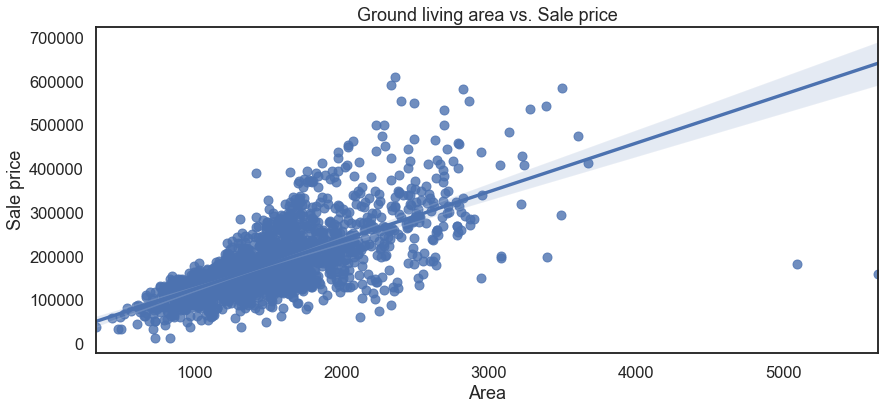

In [54]:
plt.figure(figsize=(14,6))
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'])
plt.title('Ground living area vs. Sale price')
plt.xlabel('Area')
plt.ylabel('Sale price')
plt.savefig('../images/eda6.png', transparent=True);

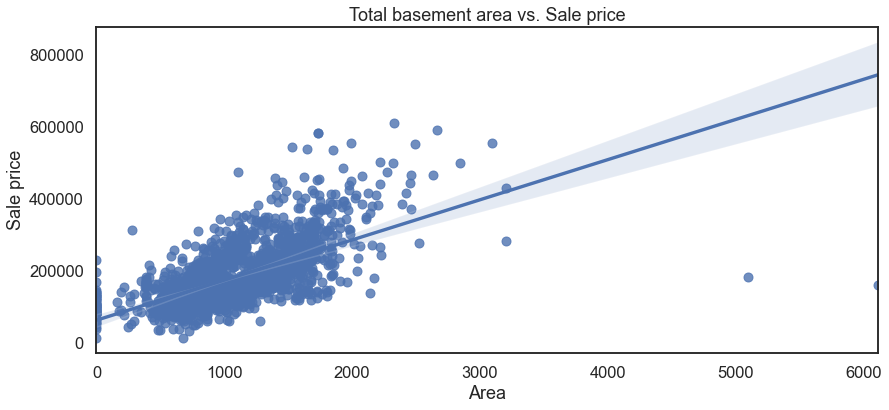

In [55]:
plt.figure(figsize=(14,6))
sns.regplot(x=train['TotalBsmtSF'], y=train['SalePrice'])
plt.title('Total basement area vs. Sale price')
plt.xlabel('Area')
plt.ylabel('Sale price')
plt.savefig('../images/eda7.png', transparent=True);

In [56]:
train['total_sqft'] = train['GrLivArea'] + train['TotalBsmtSF'] 
test['total_sqft'] = test['GrLivArea'] + test['TotalBsmtSF']
X_train['total_sqft'] = X_train['GrLivArea'] + X_train['TotalBsmtSF'] 
X_hold['total_sqft'] = X_hold['GrLivArea'] + X_hold['TotalBsmtSF'] 

<ipython-input-56-f67dbdd889b5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['total_sqft'] = X_train['GrLivArea'] + X_train['TotalBsmtSF']
<ipython-input-56-f67dbdd889b5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_hold['total_sqft'] = X_hold['GrLivArea'] + X_hold['TotalBsmtSF']


### Years since remod

Years since remodelling seem to tell a compelling relationship with saleprice, we want to change this to something that we can use to model. In below scenario, we convert to the age since last remodelling by subtracting the current year against `YearRemod/Add`.

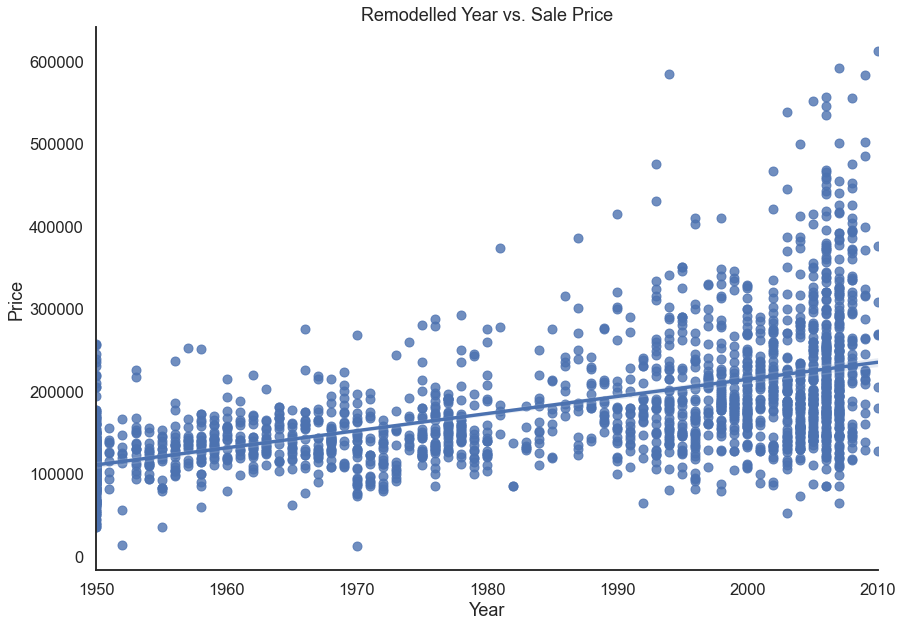

In [57]:
plt.figure(figsize=(14,10))
sns.regplot(x=train['YearRemod/Add'], y=train['SalePrice'])
sns.despine()
plt.title('Remodelled Year vs. Sale Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.savefig('../images/YearSinceRemod.png', transparent=True);

In [58]:
train['YearsSinceRemod'] = 2010 - train['YearRemod/Add']
test['YearsSinceRemod'] = 2010 - test['YearRemod/Add']
X_train['YearsSinceRemod'] = 2010 - X_train['YearRemod/Add']
X_hold['YearsSinceRemod'] = 2010 - X_hold['YearRemod/Add']

<ipython-input-58-7d749fff6ddd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['YearsSinceRemod'] = 2010 - X_train['YearRemod/Add']
<ipython-input-58-7d749fff6ddd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_hold['YearsSinceRemod'] = 2010 - X_hold['YearRemod/Add']


### Age

We can also do something similar for age of the house by subtracting the current year against `YearBuilt`.

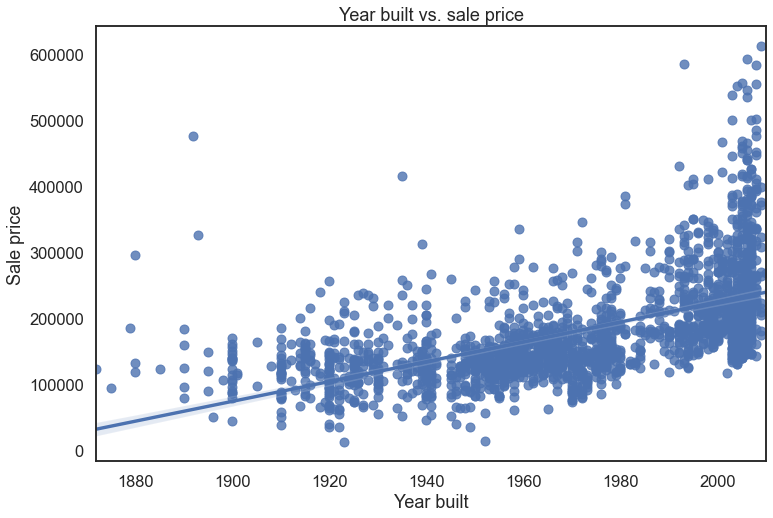

In [59]:
plt.figure(figsize=(12,8))
sns.set_context('talk')
sns.regplot(x=train['YearBuilt'], y=train['SalePrice'])
plt.title('Year built vs. sale price')
plt.xlabel('Year built')
plt.ylabel('Sale price')
plt.savefig('../images/eda5.png', transparent=True);

In [60]:
train['Age'] = 2010 - train['YearBuilt']
test['Age'] = 2010 - test['YearBuilt']
X_train['Age'] = 2010 - X_train['YearBuilt']
X_hold['Age'] = 2010 - X_hold['YearBuilt']

<ipython-input-60-b61e62c84739>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Age'] = 2010 - X_train['YearBuilt']
<ipython-input-60-b61e62c84739>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_hold['Age'] = 2010 - X_hold['YearBuilt']


## Scale dataset (train + holdout)

We need to drop categorical features and scale the numerical features before we can add the categorical features back.

In [61]:
cat_cols = X_train.select_dtypes(include=['object']).columns

X_train_num = X_train.drop(columns=cat_cols)
X_hold_num = X_hold.drop(columns=cat_cols)

num_cols = X_train.select_dtypes(exclude=['object']).columns

ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_num[num_cols[1:]])
X_hold_scaled = ss.transform(X_hold_num[num_cols[1:]])

df_X_train = pd.DataFrame(X_train_scaled)
df_X_train.columns = num_cols[1:]

df_X_hold = pd.DataFrame(X_hold_scaled)
df_X_hold.columns = num_cols[1:]

X_train_scaled = pd.concat([df_X_train, X_train[['Id']].reset_index(drop=True)], axis=1)
X_hold_scaled = pd.concat([df_X_hold, X_hold[['Id']].reset_index(drop=True)], axis=1)

### Categorical feature selection for model

I tried selecting a couple of categoriacl features to add to the model. Turns out that I was getting worst scores when I sacrifice out other numerical variables for categorical dummies. I decided not to add these categorical features in my model.

In [62]:
X_train_cat = X_train[cat_cols]
X_hold_cat = X_hold[cat_cols]

Here we shortlist some categorical features that we can 'dummy' and add to our model.

`MSZoning`

<AxesSubplot:xlabel='MSZoning', ylabel='SalePrice'>

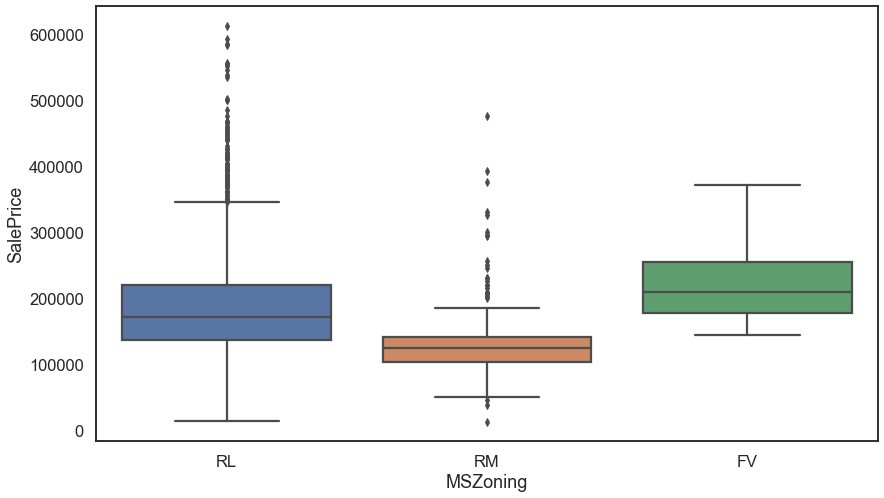

In [63]:
plt.figure(figsize=(14,8))
sns.boxplot(x=train['MSZoning'], y=train['SalePrice'])

In [64]:
MSZoning_X_train = pd.get_dummies(X_train_cat['MSZoning'], drop_first=True, prefix='MSZoning')
MSZoning_X_hold = pd.get_dummies(X_hold_cat['MSZoning'], drop_first=True, prefix='MSZoning')

X_train_scaled = pd.concat([X_train_scaled, MSZoning_X_train.reset_index(drop=True)], axis=1)
X_hold_scaled = pd.concat([X_hold_scaled, MSZoning_X_hold.reset_index(drop=True)], axis=1)

MSZoning was dropped subsequently as the effect to the model wasnt significant.

`Foundation`

<AxesSubplot:xlabel='Foundation', ylabel='SalePrice'>

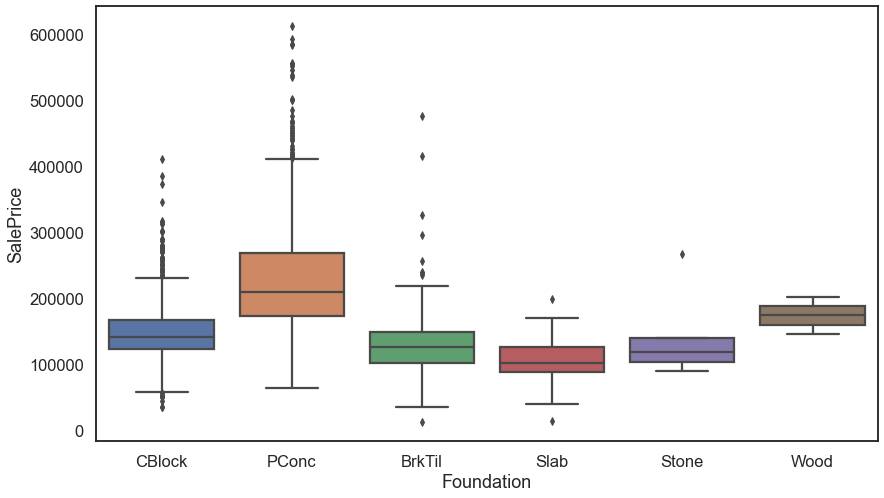

In [65]:
plt.figure(figsize=(14,8))
sns.boxplot(x=train['Foundation'], y=train['SalePrice'])

In [66]:
Foundation_X_train = pd.get_dummies(X_train_cat['Foundation'], drop_first=True, prefix='Foundation')
Foundation_X_hold = pd.get_dummies(X_hold_cat['Foundation'], drop_first=True, prefix='Foundation')

X_train_scaled = pd.concat([X_train_scaled, Foundation_X_train.reset_index(drop=True)], axis=1)
X_hold_scaled = pd.concat([X_hold_scaled, Foundation_X_hold.reset_index(drop=True)], axis=1)

# Modelling

## Hold-out set

### Feature controlling

This section is used for me to control the features to add/remove from my model.

In [67]:
cols_to_drop = [
    '1stFlrSF',
    'ScreenPorch',
    'BsmtFullBath',
    'TotRmsAbvGrd',
    'LandContour',
    'LotArea',
    'BsmtFinType1',
    'YearsSinceRemod',
    'PoolArea',
    'HeatingQC',
    'WoodDeckSF',
    'Functional',
    'FullBath',
    'GarageYrBlt',
    'YearRemod/Add',
    'YearBuilt',
    'OpenPorchSF',
    'GarageCond',
    'PavedDrive',
    'BsmtFinType2',
    'EnclosedPorch',
    '3SsnPorch',
    'LotShape',
    'MoSold',
    'YrSold',
    'GarageQual',
    'LandSlope',
    'Utilities',
    'GarageFinish',
    'BsmtFinSF2',
    'ExterCond',
    'OverallCond',
    'KitchenAbvGr',
    'BedroomAbvGr',
    'HalfBath',
]

In [68]:
X_train_model = X_train_scaled.drop(columns=['Id'])
X_hold_model = X_hold_scaled.drop(columns=['Id'])

In [69]:
X_train_model = X_train_model.drop(columns=cols_to_drop)
X_hold_model = X_hold_model.drop(columns=cols_to_drop)

In [70]:
X_train_model

,MSSubClass,LotFrontage,OverallQual,MasVnrArea,ExterQual,BsmtQual,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,CentralAir,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtHalfBath,KitchenQual,Fireplaces,GarageCars,GarageArea,MiscVal,total_sqft,Age,MSZoning_RL,MSZoning_RM,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood
0,0.334991,1.721667,0.613255,-0.566024,-0.687782,-0.553978,0.108769,-0.582809,-0.328080,0.332221,-0.119526,0.268099,1.599906,-0.105054,1.558217,-0.252917,-0.762155,2.200473,0.293508,0.110189,-0.086097,0.879350,1.137844,1,0,1,0,0,0,0
1,-0.856917,-0.426385,-0.767917,-0.566024,-0.687782,-0.553978,0.108769,-0.582809,-0.095884,-0.569561,-0.430328,0.268099,-0.772901,-0.105054,-1.273050,-0.252917,0.721584,-0.924748,0.293508,1.124401,-0.086097,-1.011801,0.709786,1,0,1,0,0,0,0
2,0.573373,-0.015056,0.613255,-0.566024,-0.687782,0.555423,0.108769,1.262952,0.353732,0.016597,0.283856,0.268099,-0.772901,-0.105054,-0.560693,-0.252917,0.721584,-0.924748,0.293508,0.105620,-0.086097,-0.182586,-0.607316,1,0,0,1,0,0,0
3,0.096610,-0.015056,1.303841,2.115023,0.997119,0.555423,0.108769,1.262952,-0.936011,1.515809,0.402887,0.268099,2.178352,-0.105054,2.030431,-0.252917,0.721584,0.637862,1.600259,1.266026,-0.086097,1.456249,-0.771954,1,0,0,1,0,0,0
4,-0.141772,-0.426385,-0.077331,-0.566024,-0.687782,-0.553978,0.108769,-0.582809,-0.936011,0.469742,-0.619896,0.268099,0.513845,-0.105054,-0.011794,-0.252917,-0.762155,0.637862,-1.013242,-1.068491,-0.086097,-0.351613,1.039062,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,2.480426,-1.249043,-0.077331,-0.566024,-0.687782,0.555423,0.108769,-0.582809,0.830789,-1.047505,-0.258395,0.268099,2.131132,-0.105054,2.070792,-0.252917,-0.762155,0.637862,0.293508,0.466534,-0.086097,1.113294,-0.047548,0,1,1,0,0,0,0
1532,-0.618535,1.127525,-1.458503,-0.566024,-0.687782,-1.663379,0.108769,-0.582809,-0.936011,0.203717,-0.880000,-3.729963,-0.772901,-0.105054,-1.490995,-0.252917,-0.762155,-0.924748,0.293508,-0.154786,-0.086097,-1.393951,1.467120,1,0,0,0,0,0,0
1533,0.811755,0.030647,-0.767917,0.124374,-0.687782,-0.553978,0.108769,1.262952,0.759019,-0.601123,0.103106,0.268099,-0.772901,-0.105054,-0.615179,-0.252917,-0.762155,-0.924748,0.293508,0.302067,-0.086097,-0.316093,0.314655,1,0,1,0,0,0,0
1534,0.573373,0.030647,-0.767917,-0.094252,-0.687782,-0.553978,0.108769,1.262952,-0.199317,-1.232370,-1.514831,0.268099,0.485513,-0.105054,-0.778638,3.711169,-0.762155,-0.924748,-1.013242,-0.849201,-0.086097,-1.314337,0.018307,1,0,1,0,0,0,0


### Linear regression

In [71]:
lr = LinearRegression()
lr.fit(X_train_model, y_train)

LinearRegression()

In [72]:
cross_val_score(lr, X_train_model, y_train, scoring='neg_root_mean_squared_error').mean()

-35669.60426877132

In [73]:
cross_val_score(lr, X_hold_model, y_hold, scoring='neg_root_mean_squared_error').mean()

-27906.77487250042

In [74]:
lr_coefs = pd.DataFrame({'variable':X_train_model.columns,
                            'coef':lr.coef_,
                            'abs_coef':np.abs(lr.coef_)})

lr_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lr_coefs.head(50)

,variable,coef,abs_coef
14,GrLivArea,19819.652360,19819.652360
27,Foundation_Slab,19104.703494,19104.703494
2,OverallQual,17736.395359,17736.395359
28,Foundation_Stone,13627.673780,13627.673780
29,Foundation_Wood,11312.726165,11312.726165
16,KitchenQual,9653.168291,9653.168291
4,ExterQual,9583.394921,9583.394921
5,BsmtQual,9501.244444,9501.244444
21,total_sqft,9219.758078,9219.758078
0,MSSubClass,-8865.101132,8865.101132


### Lasso

In [75]:
lasso_model = LassoCV(n_alphas=100, cv=5)
lasso_model.fit(X_train_model, y_train)

LassoCV(cv=5)

In [76]:
lasso_model.alpha_

2400.513599233821

In [77]:
lasso = Lasso(lasso_model.alpha_)
lasso.fit(X_train_model, y_train)

Lasso(alpha=2400.513599233821)

In [78]:
cross_val_score(lasso, X_train_model, y_train, scoring='neg_root_mean_squared_error').mean()

-34988.942195016876

In [79]:
cross_val_score(lasso, X_hold_model, y_hold, scoring='neg_root_mean_squared_error').mean()

-27663.217161707165

In [80]:
lasso_coefs = pd.DataFrame({'variable':X_train_model.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(50)

,variable,coef,abs_coef
2,OverallQual,18498.797425,18498.797425
14,GrLivArea,17053.305814,17053.305814
4,ExterQual,10124.689495,10124.689495
16,KitchenQual,9221.341495,9221.341495
21,total_sqft,6305.641900,6305.641900
7,BsmtExposure,6033.469339,6033.469339
8,BsmtFinSF1,5641.947076,5641.947076
0,MSSubClass,-5460.267739,5460.267739
18,GarageCars,5322.773876,5322.773876
20,MiscVal,-4307.850293,4307.850293


### Ridge

In [81]:
ridge_alphas = np.logspace(0, 5, 200)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=5)
optimal_ridge.fit(X_train_model, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.05956018e+00, 1.12266777e+00, 1.18953407e+00,
       1.26038293e+00, 1.33545156e+00, 1.41499130e+00, 1.49926843e+00,
       1.58856513e+00, 1.68318035e+00, 1.78343088e+00, 1.88965234e+00,
       2.00220037e+00, 2.12145178e+00, 2.24780583e+00, 2.38168555e+00,
       2.52353917e+00, 2.67384162e+00, 2.83309610e+00, 3.00183581e+00,
       3.18062569e+00, 3.37006433e+0...
       2.64308149e+04, 2.80050389e+04, 2.96730241e+04, 3.14403547e+04,
       3.33129479e+04, 3.52970730e+04, 3.73993730e+04, 3.96268864e+04,
       4.19870708e+04, 4.44878283e+04, 4.71375313e+04, 4.99450512e+04,
       5.29197874e+04, 5.60716994e+04, 5.94113398e+04, 6.29498899e+04,
       6.66991966e+04, 7.06718127e+04, 7.48810386e+04, 7.93409667e+04,
       8.40665289e+04, 8.90735464e+04, 9.43787828e+04, 1.00000000e+05]),
        cv=5)

In [82]:
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(X_train_model, y_train)

Ridge(alpha=488.02515836544336)

In [83]:
cross_val_score(ridge, X_train_model, y_train, scoring='neg_root_mean_squared_error').mean()

-34635.7336824431

In [84]:
cross_val_score(ridge, X_hold_model, y_hold, scoring='neg_root_mean_squared_error').mean()

-30786.616298110028

In [85]:
ridge_coefs = pd.DataFrame({'variable':X_train_model.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_)})

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

ridge_coefs.head(40)

,variable,coef,abs_coef
2,OverallQual,12559.069621,12559.069621
14,GrLivArea,10530.685350,10530.685350
16,KitchenQual,9250.967601,9250.967601
4,ExterQual,9224.735133,9224.735133
21,total_sqft,8328.767850,8328.767850
7,BsmtExposure,6193.259685,6193.259685
5,BsmtQual,5486.625109,5486.625109
17,Fireplaces,5424.991952,5424.991952
0,MSSubClass,-5272.937462,5272.937462
18,GarageCars,4993.736613,4993.736613


## Test set

### Data manipulation and scaling

In [86]:
y_train = train['SalePrice']

### Scale dataset (train + test)

Drop categorical columns for now

In [87]:
cat_cols = train.select_dtypes(include=['object']).columns

train_cat = train[cat_cols]
test_cat = test[cat_cols]

train_num = train.drop(columns=cat_cols)
test_num = test.drop(columns=cat_cols)

num_cols = train.select_dtypes(exclude=['object']).columns
num_cols = num_cols.drop('SalePrice')

In [88]:
ss = StandardScaler()
train_scaled = ss.fit_transform(train_num[num_cols[1:]])
test_scaled = ss.transform(test_num[num_cols[1:]])

df_train_scaled = pd.DataFrame(train_scaled)
df_train_scaled.columns = num_cols[1:]

df_test_scaled = pd.DataFrame(test_scaled)
df_test_scaled.columns = num_cols[1:]

train_scaled = pd.concat([df_train_scaled, train[['Id']].reset_index(drop=True)], axis=1)
test_scaled = pd.concat([df_test_scaled, test[['Id']].reset_index(drop=True)], axis=1)

Concat dummy variables for `MSZoning` and `Foundation`.

In [89]:
MSZoning_X_train = pd.get_dummies(train['MSZoning'], drop_first=True, prefix='MSZoning')
MSZoning_X_test = pd.get_dummies(test['MSZoning'], drop_first=True, prefix='MSZoning')

train_scaled = pd.concat([train_scaled, MSZoning_X_train.reset_index(drop=True)], axis=1)
test_scaled = pd.concat([test_scaled, MSZoning_X_test.reset_index(drop=True)], axis=1)

In [90]:
Foundation_X_train = pd.get_dummies(train['Foundation'], drop_first=True, prefix='Foundation')
Foundation_X_test = pd.get_dummies(test['Foundation'], drop_first=True, prefix='Foundation')

train_scaled = pd.concat([train_scaled, Foundation_X_train.reset_index(drop=True)], axis=1)
test_scaled = pd.concat([test_scaled, Foundation_X_test.reset_index(drop=True)], axis=1)

### Feature controlling

In [91]:
X_train_model_final = train_scaled.drop(columns=['Id'])
X_test_model_final = test_scaled.drop(columns=['Id'])

X_train_model_final = X_train_model_final.drop(columns=cols_to_drop)
X_test_model_final = X_test_model_final.drop(columns=cols_to_drop)

### Linear regression

In [92]:
lr = LinearRegression()
lr.fit(X_train_model_final, y_train)

LinearRegression()

In [93]:
cross_val_score(lr, X_train_model_final, y_train, scoring='neg_root_mean_squared_error').mean()

-33334.317494040864

In [94]:
lr_coefs = pd.DataFrame({'variable':X_train_model_final.columns,
                            'coef':lr.coef_,
                            'abs_coef':np.abs(lr.coef_)})

lr_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lr_coefs.head(50)

,variable,coef,abs_coef
28,Foundation_Stone,21313.459079,21313.459079
14,GrLivArea,19725.264409,19725.264409
2,OverallQual,17895.253285,17895.253285
27,Foundation_Slab,17393.972833,17393.972833
21,total_sqft,10910.946651,10910.946651
16,KitchenQual,9010.382598,9010.382598
4,ExterQual,8877.374128,8877.374128
5,BsmtQual,8486.833615,8486.833615
0,MSSubClass,-8103.463265,8103.463265
7,BsmtExposure,6996.891553,6996.891553


### Lasso

In [95]:
lasso_model = LassoCV(n_alphas=100, cv=5)
lasso_model.fit(X_train_model_final, y_train)

LassoCV(cv=5)

In [96]:
lasso_model.alpha_

838.913333331741

In [97]:
lasso = Lasso(lasso_model.alpha_)
lasso.fit(X_train_model_final, y_train)

Lasso(alpha=838.913333331741)

In [98]:
cross_val_score(lasso, X_train_model_final, y_train, scoring='neg_root_mean_squared_error').mean()

-32997.98596395318

In [99]:
lasso_coefs = pd.DataFrame({'variable':X_train_model_final.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs

,variable,coef,abs_coef
14,GrLivArea,20281.113482,20281.113482
2,OverallQual,17945.513542,17945.513542
4,ExterQual,9371.171041,9371.171041
16,KitchenQual,9039.204730,9039.204730
0,MSSubClass,-7302.036685,7302.036685
8,BsmtFinSF1,7142.124783,7142.124783
7,BsmtExposure,6620.851430,6620.851430
3,MasVnrArea,5345.270095,5345.270095
20,MiscVal,-5228.980800,5228.980800
21,total_sqft,4749.231239,4749.231239


### Ridge

In [100]:
ridge_alphas = np.logspace(0, 5, 200)
optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=5)
optimal_ridge.fit(X_train_model_final, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.05956018e+00, 1.12266777e+00, 1.18953407e+00,
       1.26038293e+00, 1.33545156e+00, 1.41499130e+00, 1.49926843e+00,
       1.58856513e+00, 1.68318035e+00, 1.78343088e+00, 1.88965234e+00,
       2.00220037e+00, 2.12145178e+00, 2.24780583e+00, 2.38168555e+00,
       2.52353917e+00, 2.67384162e+00, 2.83309610e+00, 3.00183581e+00,
       3.18062569e+00, 3.37006433e+0...
       2.64308149e+04, 2.80050389e+04, 2.96730241e+04, 3.14403547e+04,
       3.33129479e+04, 3.52970730e+04, 3.73993730e+04, 3.96268864e+04,
       4.19870708e+04, 4.44878283e+04, 4.71375313e+04, 4.99450512e+04,
       5.29197874e+04, 5.60716994e+04, 5.94113398e+04, 6.29498899e+04,
       6.66991966e+04, 7.06718127e+04, 7.48810386e+04, 7.93409667e+04,
       8.40665289e+04, 8.90735464e+04, 9.43787828e+04, 1.00000000e+05]),
        cv=5)

In [101]:
ridge = Ridge(alpha=optimal_ridge.alpha_)
ridge.fit(X_train_model_final, y_train)

Ridge(alpha=325.508859983506)

In [102]:
cross_val_score(ridge, X_train_model_final, y_train, scoring='neg_root_mean_squared_error').mean()

-32935.83089329673

In [103]:
ridge_coefs = pd.DataFrame({'variable':X_train_model_final.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_)})

ridge_coefs.sort_values('abs_coef', inplace=True, ascending=False)

ridge_coefs.head(40)

,variable,coef,abs_coef
2,OverallQual,14381.732586,14381.732586
14,GrLivArea,12551.310663,12551.310663
21,total_sqft,9475.576084,9475.576084
16,KitchenQual,9178.843025,9178.843025
4,ExterQual,9046.131993,9046.131993
7,BsmtExposure,6328.476549,6328.476549
0,MSSubClass,-6026.829218,6026.829218
3,MasVnrArea,5883.127234,5883.127234
5,BsmtQual,5430.548332,5430.548332
17,Fireplaces,5290.485197,5290.485197


### Predicting and submitting to Kaggle

Overall, all 3 models gave very close scores. I've decided to go with Lasso for my preferred regularization method as that was the model which I utilized to eliminate features. 

In [104]:
y_preds = lasso.predict(X_test_model_final)

In [105]:
submit = pd.DataFrame()
submit['Id'] = test['Id']
submit['SalePrice'] = y_preds
submit.sort_values(by='Id', inplace=True)
submit
submit.to_csv('../datasets/submit.csv', index=False)

![image info](../images/kaggle3.png)

# Conclusion

![image info](../images/conclusion2.png)